# Machine Learning for Time Domain Astronomy
ZTF Summer School 2023

----

**First, please visit the ZTF website at: https://ztf.caltech.edu to learn understand what exciting science is being done with ZTF data!**


Requirements:
- Matrix Convolution/Kernel operations: https://en.wikipedia.org/wiki/Kernel_(image_processing)
- Neural Networks/Perceptron: http://neuralnetworksanddeeplearning.com/chap1.html#perceptrons
- Convolutional Neural Networks (CNN): http://neuralnetworksanddeeplearning.com/chap6.html#introducing_convolutional_networks
- Tensorflow and Keras, which we'll use to create the models and train them: https://www.tensorflow.org/tutorials/keras/classification
- ZTF alerts: https://www.ztf.caltech.edu/ztf-alert-stream.html and https://iopscience.iop.org/article/10.1088/1538-3873/aae904/pdf

Optional, but recommended:
- Weights and Biases Quickstart: https://docs.wandb.ai/quickstart (you will need to create an account anyway!)
- Early stopping: https://en.wikipedia.org/wiki/Early_stopping
- Dropout: https://en.wikipedia.org/wiki/Dilution_(neural_networks)
- Plateau phenomenon: https://analyticsindiamag.com/what-is-the-plateau-problem-in-neural-networks-and-how-to-fix-it


----

Overview:

We'll have a look at how the alert scanning process can be automatized (or at least facilitated) by teaching neural networks how to look at the cutouts and metadata from the alert packets just like humans would. We'll talk about the model's architecture, how to train it, evaluate it, and how to fine-tune it with the help of wandb.ai.


----

##### Requirements:
1. Python 3.8 or later
2. Simply install the requirements with `pip install -r requirements.txt`

In [2]:
# but of course, let's start with the imports
import numpy as np
import pandas as pd
import tensorflow as tf
import wandb
from ast import literal_eval
import scipy
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,  precision_score, recall_score, f1_score

##### Downloading the dataset:
1. Go to https://drive.usercontent.google.com/download?id=16ufsYYbpJ0ZWw2ZIibPfQQ81k7OBNl9Z&export=download&authuser=0
2. Place the downloaded ZIP file in the same directory as this notebook
3. Unzip the file, and you're ready to go!

----

## Introduction

### Quick reminder: Convolutional Neural Network (CNN)

"In deep learning, a convolutional neural network (CNN) is a class of artificial neural network most commonly applied to analyze visual imagery.[1] CNNs use a mathematical operation called convolution in place of general matrix multiplication in at least one of their layers.[2] They are specifically designed to process pixel data and are used in image recognition and processing."
*https://en.wikipedia.org/wiki/Convolutional_neural_network*

<img src="https://miro.medium.com/v2/resize:fit:1162/format:webp/1*tvwYybdIwvoOs0DuUEJJTg.png" alt="Drawing" style="width: 800px;"/>
<p style="font-size: 10px;">Source: https://medium.com/techiepedia/binary-image-classifier-cnn-using-tensorflow-a3f5d6746697</p>


A basic CNN is composed of several layers:
- Convolutional layers: they apply a convolution operation to the input, passing the result to the next layer.
- Pooling layers: they downsample the input along the spatial dimensions (width, height), reducing the number of parameters and computation in the network.
- Fully connected layers: they compute the class scores, resulting in a vector of size equal to the number of classes. If the classification we expect is binary (simply True if >0.5, otherwise False), the last layer is a single neuron with a sigmoid activation function.

The input can be either a single image, composed of one or more channels (e.g. RGB), or a batch of images of the same size. When it comes to the cutouts found in the ZTF alert packets, they are a set of 3 images (science, template, difference) of size 63x63 pixels, each with 1 channel (grayscale). Meaning the imput is of size (63, 63, 3).

<img src="./alert_cutouts.png" alt="Drawing" style="width: 800px;"/>
<p style="font-size: 10px;">Screenshot (from fritz.science) of the cutouts from the latest alert for ZTF23aaqqfac</p>

### What about metadata?

Often, the data available isn't just one or more image, but also metadata that was computed which can be used to improve the classification. For example, the metadata can be the position of the object, the time of the observation, the magnitude of the object, etc. The metadata can be used in two ways:
- As an additional input to the CNN, concatenated to the image.
- As an additional input to the CNN, concatenated to the output of the last convolutional layer.

Later in this notebook, you'll see that the process of "merging" the CNN model and the metadata (which is a classic neural network) model into one is extremely simple.

The metadata goes through its own set of fully connected layers, and the output is concatenated to the output of the last convolutional layer after it has been flattened. The resulting vector is then fed to the fully connected layers that later compute the class scores. The BTS model aims to predict one thing: the probability that the object is a bright transient, of interest for the Bright Transient Survey (BTS) group.

<img src="http://neuralnetworksanddeeplearning.com/images/tikz11.png" alt="Drawing" style="width: 800px; background-color: white;"/>
<p style="font-size: 10px;">Basic neural network with 2 hidden layers, with one neuron as an ouput to perform binary classification. Just like the one our alert metadata will go through. Source: http://neuralnetworksanddeeplearning.com/chap1.html</p>

### But why do we need AI for any of this?

<img src="https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa327668d-b172-44e7-a2b0-4671c235ce79_682x500.jpeg" alt="Drawing" style="width: 600px;"/>

"The Bright Transient Survey (BTS) relies on visual inspection (“scanning”) to select sources
for accomplishing its mission of spectroscopically classifying all bright extragalactic transients
found by the Zwicky Transient Facility (ZTF).
We present BTSbot, a multi-input convolutional
neural network, which provides a bright transient
score to individual ZTF detections using their image data and 14 extracted features. BTSbot eliminates the need for scanning by automatically identifying and requesting follow-up observations of
new bright (magpsf < 18.5 mag) transient candidates.
In validation, BTSbot outperforms BTS scanners in terms of completeness (99% vs. 95%) and
identification speed (on average, 7.4 h quicker)."

Source: Nabeel Rehemtulla, BTSbot's creator :)

To summarize: Instead of relying on people to look at thousands of alerts every day to find which ones are worth getting a spectrum for, we train a model to do it for us. Just like a person scanning, the model can look at both images and metadata, except more consistently and orders of magnitude faster.

----

## BTS model

As mentioned earlier, the model comprises two parts: the CNN and the metadata part, merged to yield one output. Here is what it looks like:

### Architecture:

CNN model:
- 2 blocks of 2 convolutional layers, each followed by a pooling layer, and a dropout layer.
- a flatten layer.

Metadata model:
- 2 fully connected layers.

Merged model:
- the output of the flatten layer of the CNN model is concatenated to the output of the metadata model.
- Followed by one fully connected layer, a dropout layer, and the output layer (a single neuron with a sigmoid activation function).


In [3]:
# we define some basic constants.
config = {
    'image_size': (63,63,3),
    'metadata_size': (14,),
    'dropout_1': 0.3,
    'dropout_2': 0.3,
    'dropout_3': 0.3,
}

Inputs:

In [4]:
# first we prepare the input layers
triplet_input = keras.Input(shape=config["image_size"], name='triplet')
meta_input = keras.Input(shape=config["metadata_size"], name='metadata')

CNN part of the model:

In [5]:
# first conv block
x_conv = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(63, 63, 3), name='conv1')(triplet_input)
x_conv = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2')(x_conv)
x_conv = MaxPooling2D(pool_size=(2, 2), name='pool1')(x_conv)
x_conv = Dropout(config["dropout_1"], name='drop1')(x_conv)

# second conv block
x_conv = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv3')(x_conv)
x_conv = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv4')(x_conv)
x_conv = MaxPooling2D(pool_size=(4, 4), name='pool2')(x_conv)
x_conv = Dropout(config["dropout_2"], name='drop2')(x_conv)

# we flatten the output
x_conv = Flatten()(x_conv)

Metadata part of the model:

In [6]:
# Metadata model
x_meta = Dense(16, activation='relu', name='metadata_fc_1')(meta_input)
x_meta = Dense(32, activation='relu', name='metadata_fc_2')(x_meta)

Putting it all together:

In [7]:
# Merged model
x = Concatenate(axis=1)([x_conv, x_meta])
x = Dense(16, activation='relu', name='comb_fc_2')(x)
x = Dropout(config["dropout_3"])(x)

# Output (binary classification, a single sigmoid neuron giving us a score between 0 (not BTS) and 1 (BTS!!!))
output = Dense(1, activation='sigmoid', name='fc_out')(x)

We compile the model:

In [8]:
model = keras.Model(inputs=[triplet_input, meta_input], outputs=output, name="mi_cnn")

Let's have a look at the model with a graph:

<img src="./model.png" alt="Drawing" style="width: 500px;"/>

Easy, right? :)

Let's just test it on a fake input, to verify that the model is working as expected (all the layers are connected correctly, the inputs and outputs has the right shape, etc.)

In [9]:
fake_triplet = np.zeros((1, 63, 63, 3))
fake_meta = np.zeros((1, 14))

model.predict([fake_triplet, fake_meta])

1/1 [==============================] - 1s 723ms/step


array([[0.5]], dtype=float32)

Let's just refactor all this to have a nice method to instantiate a model:

In [10]:
def BTSModel(config):
    #image size and metadata size might be strings, so we convert them to tuples with a literal eval
    if type(config["image_size"]) == str:
        image_size = literal_eval(config["image_size"])
    else:
        image_size = config["image_size"]
    if type(config["metadata_size"]) == str:
        metadata_size = literal_eval(config["metadata_size"])
    else:
        metadata_size = config["metadata_size"]

    # first we prepare the input layers
    triplet_input = keras.Input(shape=image_size, name='triplet')
    meta_input = keras.Input(shape=metadata_size, name='metadata')

    # first conv block
    x_conv = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(63, 63, 3), name='conv1')(triplet_input)
    x_conv = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2')(x_conv)
    x_conv = MaxPooling2D(pool_size=(2, 2), name='pool1')(x_conv)
    x_conv = Dropout(config["dropout_1"], name='drop1')(x_conv)

    # second conv block
    x_conv = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv3')(x_conv)
    x_conv = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv4')(x_conv)
    x_conv = MaxPooling2D(pool_size=(4, 4), name='pool2')(x_conv)
    x_conv = Dropout(config["dropout_2"], name='drop2')(x_conv)

    # we flatten the output
    x_conv = Flatten()(x_conv)

    # Metadata model
    x_meta = Dense(16, activation='relu', name='metadata_fc_1')(meta_input)
    x_meta = Dense(32, activation='relu', name='metadata_fc_2')(x_meta)

    # Merged model
    x = Concatenate(axis=1)([x_conv, x_meta])
    x = Dense(16, activation='relu', name='comb_fc_2')(x)
    x = Dropout(config["dropout_3"])(x)

    # Output (binary classification, a single sigmoid neuron giving us a score between 0 (not BTS) and 1 (BTS!!!))
    output = Dense(1, activation='sigmoid', name='fc_out')(x)

    model = keras.Model(inputs=[triplet_input, meta_input], outputs=output, name="mi_cnn")

    return model

Great, we have a model that works. But just like a baby's brain (but even worse), this thing can't do anything! It needs to be trained through trial and error, just like the scanners would. Let's spoon feed it with a ton of data so it can steal our jobs faster :)

<img src="https://styles.redditmedia.com/t5_adbcw/styles/communityIcon_anc30b6ykk461.jpg" alt="Drawing" style="width: 400px;"/>
<p style="font-size: 10px;">Source: https://www.reddit.com/r/machinelearningmemes</p>

### Training the model

We'll start by creating a training loop, which will be used to train the model.

In [11]:
# we add to our config some of the constants used in the training process
config.update({
    'batch_size': 8,
    'epochs': 10,
    'learning_rate': 0.001,
    'loss': 'binary_crossentropy',
    'optimizer': 'adam',
    'random_seed': 42,
    'train_data_version': "ZTFSS",
    'early_stopping_patience': 10,
    'LR_plateau_patience': 20,
    'reduce_LR_factor': 0.5,
    'reduce_LR_minLR': 1e-6, 
    'beta_1': 0.9,
    'beta_2': 0.999,
    'metadata_cols': [
      "sgscore1",
      "distpsnr1",
      "sgscore2",
      "distpsnr2",
      "fwhm",
      "magpsf",
      "sigmapsf",
      "ra",
      "dec",
      "diffmaglim",
      "ndethist",
      "nmtchps",
      "age",
      "peakmag_so_far"
    ],
})

In [12]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(config["random_seed"])

##### Loading the data:
For this session, the dataset is already prepared and stored for you to use. It is composed of N alerts, each with 3 cutouts (science, template, difference) and 14 metadata features (2 of these features have been computed by us based on the alert history for a given object, and do not come with the basic alert packet). The training set is used to train the model, the validation set is used to evaluate the model during training.

Later (after the training), we'll use the test set to evaluate the model on data it has never seen before. This is important to make sure the model is not overfitting the training data, and that it can generalize to new data.

In [13]:
cand = pd.read_csv(r'C:\Users\ricco\OneDrive\Desktop\ztf_summer_school_2024\lectures\01-ml\Archive\train_cand_ZTFSS.csv')
triplets = np.load(r'C:\Users\ricco\OneDrive\Desktop\ztf_summer_school_2024\lectures\01-ml\Archive\train_triplets_ZTFSS.npy', mmap_mode='r+')

# split the data into training and validation sets
val_indexes = np.random.choice(cand.index, size=int(len(cand) * 0.25), replace=False)
train_indexes = np.array(list(set(cand.index) - set(val_indexes)))

val_cand = cand.loc[val_indexes]
val_triplets = triplets[np.isin(cand.index, val_indexes)]

triplets = triplets[np.isin(cand.index, train_indexes)]
cand = cand.loc[train_indexes]

# print the shape of everything
print(f"Training set: {cand.shape[0]} candidates, {triplets.shape[0]} triplets")
print(f"Validation set: {val_cand.shape[0]} candidates, {val_triplets.shape[0]} triplets")

gen_cols = np.append(config['metadata_cols'], ['label'])

x_train, y_train = triplets, cand['label']
x_val, y_val = val_triplets, val_cand['label']

# train_df is a combination of the desired metadata cols and y_train (labels)
# we provide the model a custom generator function to separate these as necessary
train_df = cand[gen_cols]
val_df = val_cand[gen_cols]


Training set: 7770 candidates, 7770 triplets
Validation set: 2589 candidates, 2589 triplets


Next, we prepare the data a little further for the training loop. We'll use the tf.keras.preprocessing.image.ImageDataGenerator to perform some data augmentation, which will help the model generalize better.

Also, we will weight the classes to account for the class imbalance. The weight of each class is the inverse of the class frequency in the training set, in case we have more BTS than non-BTS objects, or the opposite. This will help the model learn to classify both classes equally well, and reduce the false positives and false negatives rates.

In [14]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

t_generator = train_datagen.flow(x_train, train_df, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)
v_generator = val_datagen.flow(x_val, val_df, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)

def multiinput_train_generator():
    while True:
        # get the data from the generator
        # data is [[img], [metadata and labels]]
        # yields batch_size number of entries
        data = t_generator.next()

        imgs = data[0]
        cols = data[1][:,:-1]
        targets = data[1][:,-1:]

        yield [imgs, cols], targets

def multiinput_val_generator():
    while True:
        data = v_generator.next()

        imgs = data[0]
        cols = data[1][:,:-1]
        targets = data[1][:,-1:]

        yield [imgs, cols], targets

training_generator = multiinput_train_generator()
validation_generator = multiinput_val_generator()

# weight data on number of ALERTS per class
num_training_examples_per_class = np.array([np.sum(cand['label'] == 0), np.sum(cand['label'] == 1)])

# fewer examples -> larger weight
weights = (1 / num_training_examples_per_class) / np.linalg.norm((1 / num_training_examples_per_class))
normalized_weight = weights / np.max(weights)

class_weight = {i: w for i, w in enumerate(normalized_weight)}

Instead of training our model for a fixed number of epochs, we'll use early stopping. This means that the model will train until it stops improving, and then stop. This is done by monitoring the validation loss, and stopping the training if it doesn't improve for a set number of epochs (patience).
Also, to keep training further once we plateau, we'll use a learning rate scheduler. This will reduce the learning rate by a factor of N (dividing it) once the validation loss stops improving for a set number of epochs (patience).

You might have seen in the config earlier that we still specify a number of epochs. You can see this as a maximum number of epochs, which will be reached if the model doesn't stop training before with early stopping.

In [15]:
# we set some rules to stop the training process early if the validation loss does not improve
# halt training if no improvement in validation loss over patience epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1, 
    patience=config['early_stopping_patience']
)

# reduce learning rate if no improvement in validation loss over patience epochs
LR_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", 
    patience=config['LR_plateau_patience'],
    factor=config['reduce_LR_factor'],
    min_lr=config['reduce_LR_minLR'],
    verbose=0
)

We'll use [Weights and Biases](https://wandb.ai/) to log the training metrics, and to save the model. You can create a free account on https://wandb.ai/ to log your own metrics. Later in this notebook, we'll make even better use of wandb.ai to fine-tune the model with the *sweeps* feature.

In [16]:
wandb.init(project="BTSbot")
# Send parameters of this run to WandB
for param in list(config):
    wandb.config[param] = config[param]

run_name = wandb.run.name
WandBLogger = wandb.keras.WandbMetricsLogger(log_freq=5)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ricco_vent (ml4gw). Use `wandb login --relogin` to force relogin


We'll use an Adam optimizer, which is a popular optimizer for deep learning. It is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks. It's a little more complex than the classic Stochoastic Gradient Descent (SGD) optimizer, but it's more efficient and requires less manual tuning.

In [17]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=config['learning_rate'], 
    beta_1=config['beta_1'],
    beta_2=config['beta_2']
)
model.compile(optimizer=optimizer, loss=config['loss'], metrics=['accuracy'])

#PS: If you are using tensorflow v2.11+ on M1/M2/M3 macs, you might benefit from using
# the legacy version of the optimizer, which is: tf.keras.optimizers.legacy.Adam, instead of tf.keras.optimizers.Adam

**Now (finally!), let's train the model!**

In [18]:
h = model.fit(
    training_generator,
    steps_per_epoch=0.8*len(x_train) // config["batch_size"],
    validation_data=validation_generator,
    validation_steps=(0.8*len(x_val)) // config["batch_size"],
    epochs=config["epochs"],
    verbose=1, callbacks=[early_stopping, LR_plateau, WandBLogger]
)

Epoch 1/10
777/777 [==============================] - 40s 45ms/step - loss: 0.6692 - accuracy: 0.6845 - val_loss: 0.6965 - val_accuracy: 0.6221 - lr: 0.0010
Epoch 2/10
777/777 [==============================] - 31s 40ms/step - loss: 0.5756 - accuracy: 0.7283 - val_loss: 0.7342 - val_accuracy: 0.6021 - lr: 0.0010
Epoch 3/10
777/777 [==============================] - 32s 41ms/step - loss: 0.5697 - accuracy: 0.7390 - val_loss: 0.7076 - val_accuracy: 0.6109 - lr: 0.0010
Epoch 4/10
777/777 [==============================] - 41s 53ms/step - loss: 0.5485 - accuracy: 0.7467 - val_loss: 0.7709 - val_accuracy: 0.5885 - lr: 0.0010
Epoch 5/10
777/777 [==============================] - 37s 47ms/step - loss: 0.5423 - accuracy: 0.7516 - val_loss: 0.7275 - val_accuracy: 0.6036 - lr: 0.0010
Epoch 6/10
777/777 [==============================] - 30s 39ms/step - loss: 0.5388 - accuracy: 0.7533 - val_loss: 0.7510 - val_accuracy: 0.6003 - lr: 0.0010
Epoch 7/10
777/777 [==============================] - 39s 

<a id="Testing-the-model"></a>
### Testing the model

Now, we'll load some test data to evaluate the model on data it has never seen before. This is important to make sure the model is not overfitting the training data, and that it can generalize to new data. Also, it will set a baseline for us to compare the model we'll fine-tune later.

In [19]:
raw_preds = model.predict([val_triplets, val_cand.loc[:,config["metadata_cols"]]], batch_size=config['batch_size'], verbose=1)
preds = np.rint(np.transpose(raw_preds))[0].astype(int)
labels = val_cand["label"].to_numpy(dtype=int)

results = preds == labels
print(f"Overall validation accuracy {100*np.sum(results) / len(results):.2f}%")

324/324 [==============================] - 3s 9ms/step
Overall validation accuracy 61.07%


As you can see, the accuracy is not great all, though as per the training results, it looks like the model was learning from the data as the training accuracy increased, but unfortunately the validation accuracy did not. One issue you might have noticed, is that we didn't learn all that much after the second iteration, we need to fix that.

**However**, accuracy isn't the only metric we should look at. There're a lot more metrics that can be used to evaluate a model, and it's important to look at them all to get a better idea of how the model is performing. For example, the accuracy can be misleading if the dataset is imbalanced (which is the case here). If we have 99% of non-BTS objects, and 1% of BTS objects, a model that always predicts non-BTS will have an accuracy of 99%, but it's not a good model. This is why we'll look can look at the confusion matrix, the precision, the recall, and the F1 score.

**Here is are your first set of tasks:**

1. Using matplotlib or your favorite plotting library, plot the confusion matrix for the test set. Hint: You can use the [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function to compute the confusion matrix, and the [sklearn.metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) to plot it.
2. Calculate the precision, recall, and F1 score for the test set. Hint: sklearn has some tools to help you with that :)
3. Nowadays, it's also very common to also look at a Receiver Operating Characteristic (ROC) curve and AUC: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc. Plot the ROC curve and compute the AUC for the test set.

For each of the plots and metrics you come up with, try your best to interpret the results. What do they mean? What do they tell you about the model? What can you conclude from them?

----


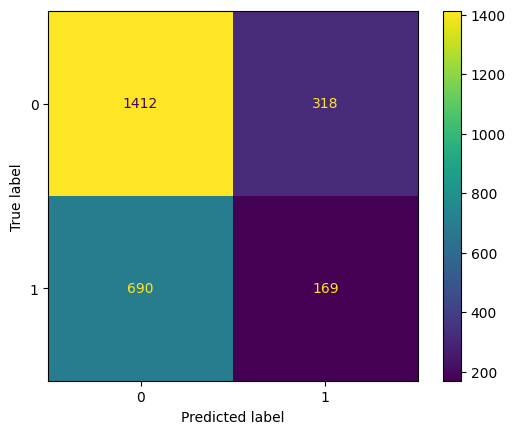

In [20]:
# confusion matrix
y_true = labels
y_pred = preds
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [21]:
# calculate precision, recall, F1
# precision score
print('Precision score:', precision_score(y_true, y_pred))

# recall score
print('Recall score:', recall_score(y_true, y_pred))

# F1 score
print('F1 score:', f1_score(y_true, y_pred))

Precision score: 0.3470225872689938
Recall score: 0.19674039580908032
F1 score: 0.2511144130757801


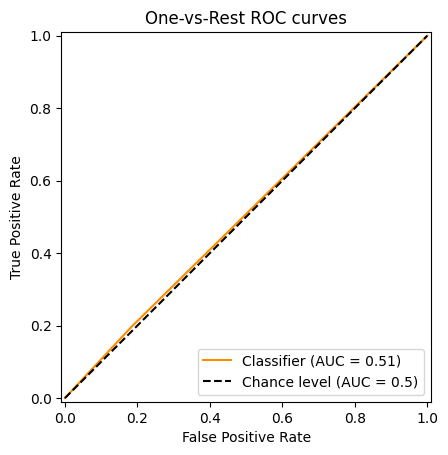

In [22]:
# ROC and AUC
# ROC
display = RocCurveDisplay.from_predictions(
    y_true,
    y_pred,
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves",
)

## Optimization: Grid search using Weights and Biases Sweeps

After looking at our basic model's result, we can easily imagine how it can be improved. One way to do that is to try different values for all of the hyperparemeters it uses, hoping to fine-tune their value to get the best result out of our existing model. This is called hyperparameter optimization, and it's a very common practice in machine learning. A great tool to do this automatically is a grid search, which will try all the possible combinations of hyperparameters you want to try, and return the best one. However, this can be very time consuming, and it's not always possible to try all the possible combinations. This is where Weights and Biases Sweeps comes in handy.

Let's use wandb.ai to fine-tune the model with their *sweeps* feature, which works pretty much like a grid search, but smarter. We'll use Weights and Biases Sweeps to perform a grid search over the hyperparameters of the model, such as: learning rate, batch size, dropout rate, etc.

First, we need to put all of the logic above in a function that we can call from the sweep configuration file.

In [23]:
def train(config):
    WandBLogger = wandb.keras.WandbMetricsLogger(log_freq=5)
    loss = config['loss']
    metadata_cols = [
        "sgscore1",
        "distpsnr1",
        "sgscore2",
        "distpsnr2",
        "fwhm",
        "magpsf",
        "sigmapsf",
        "ra",
        "dec",
        "diffmaglim",
        "ndethist",
        "nmtchps",
        "age",
        "peakmag_so_far"
    ]
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(config["random_seed"])
    
    cand = pd.read_csv(r'C:\Users\ricco\OneDrive\Desktop\ztf_summer_school_2024\lectures\01-ml\Archive\train_cand_ZTFSS.csv')
    triplets = np.load(r'C:\Users\ricco\OneDrive\Desktop\ztf_summer_school_2024\lectures\01-ml\Archive\train_triplets_ZTFSS.npy', mmap_mode='r+')
    
    # set the random seed, so we can reproduce the results
    np.random.seed(config.get("random_seed", 20240729))

    # split the data into training and validation sets
    val_indexes = np.random.choice(cand.index, size=int(len(cand) * 0.2), replace=False)
    train_indexes = np.array(list(set(cand.index) - set(val_indexes)))

    val_cand = cand.loc[val_indexes]
    val_triplets = triplets[np.isin(cand.index, val_indexes)]

    triplets = triplets[np.isin(cand.index, train_indexes)]
    cand = cand.loc[train_indexes]

    gen_cols = np.append(metadata_cols, ['label'])

    x_train, y_train = triplets, cand['label']
    x_val, y_val = val_triplets, val_cand['label']

    train_df = cand[gen_cols]
    val_df = val_cand[gen_cols]


    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1, 
        patience=config['early_stopping_patience']
    )

    LR_plateau = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", 
        patience=config['LR_plateau_patience'],
        factor=config['reduce_LR_factor'],
        min_lr=config['reduce_LR_minLR'],
        verbose=0
    )

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    t_generator = train_datagen.flow(x_train, train_df, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)
    v_generator = val_datagen.flow(x_val, val_df, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)

    def multiinput_train_generator():
        while True:
            # get the data from the generator
            # data is [[img], [metadata and labels]]
            # yields batch_size number of entries
            data = t_generator.next()

            imgs = data[0]
            cols = data[1][:,:-1]
            targets = data[1][:,-1:]

            yield [imgs, cols], targets

    def multiinput_val_generator():
        while True:
            data = v_generator.next()

            imgs = data[0]
            cols = data[1][:,:-1]
            targets = data[1][:,-1:]

            yield [imgs, cols], targets

    training_generator = multiinput_train_generator()
    validation_generator = multiinput_val_generator()

    model = BTSModel(config)
    # you might want to replace tf.keras.optimizers.Adam with tf.keras.optimizers.legacy.Adam if you are using tensorflow v2.11+ on M1/M2/M3 macs
    optimizer = tf.keras.optimizers.legacy.Adam(
        learning_rate=config['learning_rate'], 
        beta_1=config['beta_1'],
        beta_2=config['beta_2']
    )

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    model.fit(
        training_generator,
        steps_per_epoch=0.8*len(x_train) // config["batch_size"],
        validation_data=validation_generator,
        validation_steps=(0.8*len(x_val)) // config["batch_size"],
        #class_weight=class_weight,
        epochs=config["epochs"],
        verbose=1, callbacks=[early_stopping, LR_plateau, WandBLogger]
    )

    raw_preds = model.predict([triplets, cand.loc[:,metadata_cols]], batch_size=config['batch_size'], verbose=1)
    preds = np.rint(np.transpose(raw_preds))[0].astype(int)
    labels = cand["label"].to_numpy(dtype=int)

    results = preds == labels
    print(f"Overall validation accuracy {100*np.sum(results) / len(results):.2f}%")
    

In [24]:
# quick wrapper around the train function so it can be called nicely by a wandb sweep agent
def sweep_train(config=None):
    with wandb.init(config=config) as run:
        train(run.config)

Now, we'll start the grid search. No need to wait for it to finish before you can see what it is doing. You can just go to your sweep's overview page on wandb to see the progress of the grid search, and the best performing runs so far.

*Before running the next cell, you need to create a sweep on wandb.ai. You can do so by clicking on the "Sweeps" tab, and then on "Create new sweep". You can use this sweep config:
```yaml
method: bayes
metric:
  goal: minimize
  name: batch/loss
parameters:
  LR_plateau_patience:
    distribution: int_uniform
    max: 40
    min: 10
  batch_size:
    distribution: int_uniform
    max: 64
    min: 16
  beta_1:
    distribution: uniform
    max: 1.8
    min: 0.45
  beta_2:
    distribution: uniform
    max: 1.998
    min: 0.4995
  dropout_1:
    distribution: uniform
    max: 0.4
    min: 0.15
  dropout_2:
    distribution: uniform
    max: 0.4
    min: 0.15
  dropout_3:
    distribution: uniform
    max: 0.4
    min: 0.15
  early_stopping_patience:
    distribution: int_uniform
    max: 15
    min: 5
  epochs:
    distribution: int_uniform
    max: 20
    min: 5
  learning_rate:
    distribution: uniform
    max: 0.002
    min: 0.0005
  loss:
    distribution: categorical
    values:
      - binary_crossentropy
  optimizer:
    distribution: categorical
    values:
      - adam
  random_seed:
    distribution: categorical
    values: 
     - 42
  reduce_LR_factor:
    distribution: uniform
    max: 1
    min: 0.25
  reduce_LR_minLR:
    distribution: uniform
    max: 2e-06
    min: 5e-07
  train_data_version:
    distribution: categorical
    values:
      - ZTFSS
  image_size:
    distribution: categorical
    values:
      - (63,63,3)
  metadata_size:
    distribution: categorical
    values:
      - (14,)
program: train.py
```

and replace the sweep_id in the cell below with the one you get from wandb.ai.*

In [25]:
# create a sweep on WandB by going to the project page and clicking "Sweep"
sweep_id = 'tylxc8bs' #replace with your sweep id here
if not sweep_id:
    raise Exception("Please provide a sweep id")
wandb.agent(sweep_id=sweep_id, function=sweep_train, count=10, project="BTSbot")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: bw0f2rb4 with config:
wandb: 	LR_plateau_patience: 32
wandb: 	batch_size: 12
wandb: 	beta_1: 1.3036537144810787
wandb: 	beta_2: 1.5792971542600325
wandb: 	dropout_1: 0.4999509954279079
wandb: 	dropout_2: 0.4496545907700007
wandb: 	dropout_3: 0.46504358982157445
wandb: 	early_stopping_patience: 11
wandb: 	epochs: 8
wandb: 	learning_rate: 0.0006020105791137936
wandb: 	loss: binary_crossentropy
wandb: 	optimizer: adam
wandb: 	random_seed: 59
wandb: 	reduce_LR_factor: 0.9230805937994744
wandb: 	reduce_LR_minLR: 6.474655636419928e-07
wandb: 	train_data_version: ZTFSS


Traceback (most recent call last):
  File "C:\Users\ricco\AppData\Local\Temp\ipykernel_22696\231171228.py", line 4, in sweep_train
    train(run.config)
  File "C:\Users\ricco\AppData\Local\Temp\ipykernel_22696\3291317678.py", line 94, in train
    model = BTSModel(config)
            ^^^^^^^^^^^^^^^^
  File "C:\Users\ricco\AppData\Local\Temp\ipykernel_22696\4252093278.py", line 3, in BTSModel
    if type(config["image_size"]) == str:
            ~~~~~~^^^^^^^^^^^^^^
  File "c:\Users\ricco\OneDrive\Desktop\ztf_summer_school_2024\lectures\01-ml\myenv\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'image_size'


wandb: ERROR Run bw0f2rb4 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "c:\Users\ricco\OneDrive\Desktop\ztf_summer_school_2024\lectures\01-ml\myenv\Lib\site-packages\wandb\agents\pyagent.py", line 307, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "C:\Users\ricco\AppData\Local\Temp\ipykernel_22696\231171228.py", line 4, in sweep_train
wandb: ERROR     train(run.config)
wandb: ERROR   File "C:\Users\ricco\AppData\Local\Temp\ipykernel_22696\3291317678.py", line 94, in train
wandb: ERROR     model = BTSModel(config)
wandb: ERROR             ^^^^^^^^^^^^^^^^
wandb: ERROR   File "C:\Users\ricco\AppData\Local\Temp\ipykernel_22696\4252093278.py", line 3, in BTSModel
wandb: ERROR     if type(config["image_size"]) == str:
wandb: ERROR             ~~~~~~^^^^^^^^^^^^^^
wandb: ERROR   File "c:\Users\ricco\OneDrive\Desktop\ztf_summer_school_2024\lectures\01-ml\myenv\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
wandb: ERRO

Traceback (most recent call last):
  File "C:\Users\ricco\AppData\Local\Temp\ipykernel_22696\231171228.py", line 4, in sweep_train
    train(run.config)
  File "C:\Users\ricco\AppData\Local\Temp\ipykernel_22696\3291317678.py", line 94, in train
    model = BTSModel(config)
            ^^^^^^^^^^^^^^^^
  File "C:\Users\ricco\AppData\Local\Temp\ipykernel_22696\4252093278.py", line 3, in BTSModel
    if type(config["image_size"]) == str:
            ~~~~~~^^^^^^^^^^^^^^
  File "c:\Users\ricco\OneDrive\Desktop\ztf_summer_school_2024\lectures\01-ml\myenv\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'image_size'


wandb: ERROR Run 622ldatc errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "c:\Users\ricco\OneDrive\Desktop\ztf_summer_school_2024\lectures\01-ml\myenv\Lib\site-packages\wandb\agents\pyagent.py", line 307, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "C:\Users\ricco\AppData\Local\Temp\ipykernel_22696\231171228.py", line 4, in sweep_train
wandb: ERROR     train(run.config)
wandb: ERROR   File "C:\Users\ricco\AppData\Local\Temp\ipykernel_22696\3291317678.py", line 94, in train
wandb: ERROR     model = BTSModel(config)
wandb: ERROR             ^^^^^^^^^^^^^^^^
wandb: ERROR   File "C:\Users\ricco\AppData\Local\Temp\ipykernel_22696\4252093278.py", line 3, in BTSModel
wandb: ERROR     if type(config["image_size"]) == str:
wandb: ERROR             ~~~~~~^^^^^^^^^^^^^^
wandb: ERROR   File "c:\Users\ricco\OneDrive\Desktop\ztf_summer_school_2024\lectures\01-ml\myenv\Lib\site-packages\wandb\sdk\wandb_config.py", line 130, in __getitem__
wandb: ERRO

*PS: You might see that often, the loss is `nan`. This is simply because the parameters used by that particular sweep yield very bad results, which get the model to diverge. This is why it's important to have a large number of runs in the sweep, to make sure we don't miss the best hyperparameters because of a few bad runs. But also, create new sweeps with tighter constraints for some of the hyperparameters.*

----

##### We'd like you to try and beat the best score we've got so far! 

Here's what you can do:

**Go back to regular training (without any sweeps with wandb, just regular training)**

1. Try different loss functions and optimizers, and/or improve on how the initial weights are initialized.

2. Perform data augmentation on the cutouts, and use the augmented data to train the model. You can use the tf.keras.preprocessing.image.ImageDataGenerator (which you'll find in the code above already) to do this. You could also do the same for the metadata, but it's a little more complicated.

3. Play with the model's architecture. You can add, remove, or modify the layers as you wish. You could also try to use a different CNN architecture, such as ResNet, EfficientNet, etc.

4. Change the features used in the metadata model. You can add, remove, or modify the features used. You could also compute new features from the existing ones.

5. Create a new clean sweep on wandb.ai, with the configuration of your choice, adding, modifying, or removing hyperparameters as you wish. You might want to increase the worker count to cover more of the parameter space.

6. Improve time needed for inference. You can try to reduce the number of parameters in the model, or use a more efficient CNN architecture to make it more efficient. This is *key* for the model to be used in production, as we expect it to run on thousands of alerts every day.

7. Be creative! There are an infinite number of ways to improve a model, and we're sure you can come up with something we haven't thought of :)

**Once you have a model you are happy with, you should use the code you wrote in the [Testing the model](#Testing-the-model) section to evaluate it on the test set, and plot some of the metrics.**

----